In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#this function calculates one year back from most recent date
def find_one_year (max_date):
    year, month, day = max_date.split('-')
    year = str(int(year) - 1)
    day = str(int(day) + 1)
    one_year_date = year + '-' + month + '-' + day
    return one_year_date


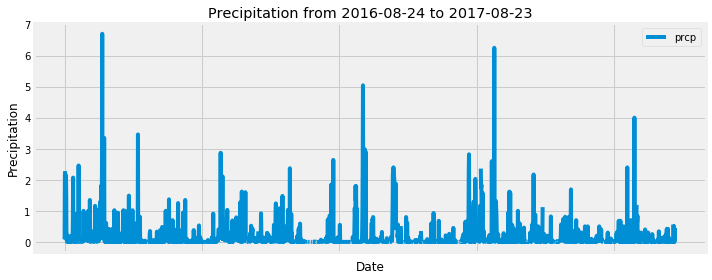

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = max_date[0]

one_year_date = find_one_year(most_recent_date)

# Perform a query to retrieve the data and precipitation scores
precip_over_yr = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= one_year_date ).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_over_yr, columns=["date","prcp"]) 

# Sort the dataframe by date
precip_df = precip_df.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_df.iloc[::1].plot(title="Precipitation from %s to %s" % (one_year_date, most_recent_date)\
    ,figsize=(10,4))

plt.ylabel("Precipitation")
plt.xlabel("Date")

plt.tight_layout()
plt.savefig("hawaii_rain.png")
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(station_count)

9


In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.date)).\
    filter(Measurement.station == Station.station).\
        group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#a function that takes a date range and filters by most active station to look for temp ranges
def find_temps(begin_date, end_date):
    session_temps = session.query(Measurement.date, Measurement.tobs).\
        filter(and_(Station.station == most_active_stations[0][0], \
            Measurement.date >= begin_date, Measurement.date <= end_date)).all()
    
    temperature_df = pd.DataFrame(session_temps, columns=["date","tobs"]) 
    
    min_temp = temperature_df["tobs"].min()
    max_temp = temperature_df["tobs"].max()
    avg_temp = temperature_df["tobs"].mean()
    
    return (min_temp, max_temp, avg_temp)

low, high, avg = find_temps(one_year_date, most_recent_date)
print(low, high, avg)

58.0 87.0 74.57894736842105


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
            filter(and_(Station.station == most_active_stations[0][0], \
                Measurement.date >= one_year_date, Measurement.date <= most_recent_date)).all()

most_active_df = pd.DataFrame(most_active_station, columns=['date', 'precipitation', 'tobs'])
most_active_df.head()

,date,precipitation,tobs
0,2016-08-24,0.08,79.0
1,2016-08-25,0.08,80.0
2,2016-08-26,0.00,79.0
3,2016-08-27,0.00,77.0
4,2016-08-28,0.01,78.0


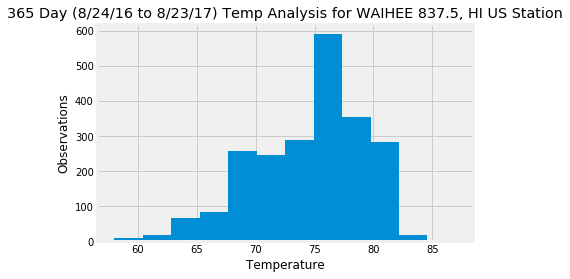

In [17]:
#plot the most active station temperature
most_active_name = session.query(Station.name).\
        filter(Station.station == most_active_stations[0][0]).scalar()

plt.hist(most_active_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.title(f"365 Day (8/24/16 to 8/23/17) Temp Analysis for {most_active_name} Station")
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    temp_calc = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    temp_df = pd.DataFrame(temp_calc, columns=['min', 'avg', 'max'])
    
    tmin = temp_df['min'].min()
    tavg = temp_df['avg'].mean()
    tmax = temp_df['max'].max()
    
    return (tmin, tavg, tmax)
    
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2015-05-15'
go_home_date = '2015-05-22'
trip_list = []

trip_list = calc_temps(trip_start_date, go_home_date)
print(calc_temps(trip_start_date, go_home_date))

(64.0, 73.3157894736842, 82.0)


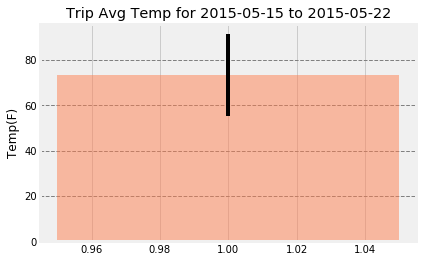

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = [1]

plt.bar(x_axis, trip_list[1], color="coral", alpha=0.5, align="center",yerr=trip_list[2] - trip_list[0], width=0.1)
plt.title("Trip Avg Temp for %s to %s" % (trip_start_date, go_home_date))
plt.ylabel("Temp(F)")
plt.grid(axis='y',color='gray', linestyle='dashed')
plt.tick_params(axis='x')
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [47]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
#             filter(and_(Measurement.station == Station.station, Measurement.date >= trip_start_date, Measurement.date <= go_home_date))\
#                   .group_by(Station.station).order_by(func.count(Measurement.prcp).desc()).all()
# rainfall

rainfall = session.query(Measurement.station, Station.name, Station.latitude, \
                Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                filter(Measurement.station == Station.station, Measurement.date >= trip_start_date,\
                       Measurement.date <= go_home_date)\
                      .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.63),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.77),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.43),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.17),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0)]